In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [32]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [33]:
DATA_PATH = 'data/stock_data.csv'
MODEL_DIR = 'models'
IMG_DIR = 'images'
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(IMG_DIR, exist_ok=True)
print("Directories created.")

Directories created.


In [34]:
print("Attempting to load data...")
try:
    df = pd.read_csv(DATA_PATH)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: {DATA_PATH} not found.")

Attempting to load data...
Data loaded successfully.


In [35]:
df

,Date,Close/Last,Volume,Open,High,Low
0,09/13/2024,$230.29,59515110,$228.00,$232.67,$226.32
1,09/12/2024,$229.81,72020040,$224.66,$231.45,$223.83
2,09/11/2024,$228.13,83548630,$224.55,$228.47,$216.8003
3,09/10/2024,$226.17,78891140,$220.07,$226.40,$218.6377
4,09/09/2024,$216.27,67443520,$216.20,$219.87,$213.67
...,...,...,...,...,...,...
2512,09/19/2014,$17.288,102014574,$17.1993,$17.4287,$17.018
2513,09/18/2014,$17.588,55342127,$17.5573,$17.7067,$17.488
2514,09/17/2014,$17.4253,77594871,$17.494,$17.6467,$17.30
2515,09/16/2014,$17.3827,124461748,$17.01,$17.4973,$16.828


In [36]:
display(df.head())

,Date,Close/Last,Volume,Open,High,Low
0,09/13/2024,$230.29,59515110,$228.00,$232.67,$226.32
1,09/12/2024,$229.81,72020040,$224.66,$231.45,$223.83
2,09/11/2024,$228.13,83548630,$224.55,$228.47,$216.8003
3,09/10/2024,$226.17,78891140,$220.07,$226.40,$218.6377
4,09/09/2024,$216.27,67443520,$216.20,$219.87,$213.67


In [37]:
df.tail()

,Date,Close/Last,Volume,Open,High,Low
2512,09/19/2014,$17.288,102014574,$17.1993,$17.4287,$17.018
2513,09/18/2014,$17.588,55342127,$17.5573,$17.7067,$17.488
2514,09/17/2014,$17.4253,77594871,$17.494,$17.6467,$17.30
2515,09/16/2014,$17.3827,124461748,$17.01,$17.4973,$16.828
2516,09/15/2014,$16.924,246507477,$18.2913,$18.2933,$16.6087


In [38]:
print(df.dtypes)

Date          object
Close/Last    object
Volume         int64
Open          object
High          object
Low           object
dtype: object


In [39]:
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Rows: 2517, Columns: 6


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2517 non-null   object
 1   Close/Last  2517 non-null   object
 2   Volume      2517 non-null   int64 
 3   Open        2517 non-null   object
 4   High        2517 non-null   object
 5   Low         2517 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.1+ KB


In [41]:
df.describe(include='all')

,Date,Close/Last,Volume,Open,High,Low
count,2517,2517,2.517000e+03,2517,2517,2517
unique,2517,2461,NaN,2398,2401,2418
top,09/13/2024,$14.006,NaN,$24.00,$198.60,$12.3333
freq,1,3,NaN,4,3,4
mean,NaN,NaN,1.122366e+08,NaN,NaN,NaN
std,NaN,NaN,7.414325e+07,NaN,NaN,NaN
min,NaN,NaN,1.065415e+07,NaN,NaN,NaN
25%,NaN,NaN,6.658297e+07,NaN,NaN,NaN
50%,NaN,NaN,9.294430e+07,NaN,NaN,NaN
75%,NaN,NaN,1.295948e+08,NaN,NaN,NaN


In [42]:
def clean_currency(x):
    if isinstance(x, str):
        return float(x.replace('$', '').replace(',', ''))
    return x

In [43]:
cols_to_clean = ['Close/Last', 'Open', 'High', 'Low']
for col in cols_to_clean:
    if col in df.columns:
        df[col] = df[col].apply(clean_currency)

In [47]:
df.rename(columns={'Close/Last': 'Close'}, inplace=True)

In [48]:
df['Date'] = pd.to_datetime(df['Date'])

In [49]:
df

,Date,Close,Volume,Open,High,Low
0,2024-09-13,230.2900,59515110,228.0000,232.6700,226.3200
1,2024-09-12,229.8100,72020040,224.6600,231.4500,223.8300
2,2024-09-11,228.1300,83548630,224.5500,228.4700,216.8003
3,2024-09-10,226.1700,78891140,220.0700,226.4000,218.6377
4,2024-09-09,216.2700,67443520,216.2000,219.8700,213.6700
...,...,...,...,...,...,...
2512,2014-09-19,17.2880,102014574,17.1993,17.4287,17.0180
2513,2014-09-18,17.5880,55342127,17.5573,17.7067,17.4880
2514,2014-09-17,17.4253,77594871,17.4940,17.6467,17.3000
2515,2014-09-16,17.3827,124461748,17.0100,17.4973,16.8280


In [51]:
df = df.sort_values('Date')
df.reset_index(drop=True, inplace=True)

In [52]:
df

,Date,Close,Volume,Open,High,Low
0,2014-09-15,16.9240,246507477,18.2913,18.2933,16.6087
1,2014-09-16,17.3827,124461748,17.0100,17.4973,16.8280
2,2014-09-17,17.4253,77594871,17.4940,17.6467,17.3000
3,2014-09-18,17.5880,55342127,17.5573,17.7067,17.4880
4,2014-09-19,17.2880,102014574,17.1993,17.4287,17.0180
...,...,...,...,...,...,...
2512,2024-09-09,216.2700,67443520,216.2000,219.8700,213.6700
2513,2024-09-10,226.1700,78891140,220.0700,226.4000,218.6377
2514,2024-09-11,228.1300,83548630,224.5500,228.4700,216.8003
2515,2024-09-12,229.8100,72020040,224.6600,231.4500,223.8300


In [54]:
dupes = df.duplicated().sum()
print(f"Duplicate rows found: {dupes}")
if dupes > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicates removed.")

Duplicate rows found: 0


In [55]:
print(df.isnull().sum())

Date      0
Close     0
Volume    0
Open      0
High      0
Low       0
dtype: int64


In [56]:
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True) 
print("Missing values handled.")

Missing values handled.


In [59]:
def plot_hist(df, column, color):
    plt.figure(figsize=(10, 4))
    sns.histplot(df[column], kde=True, color=color)
    plt.title(f'Distribution of {column}')
    plt.show()

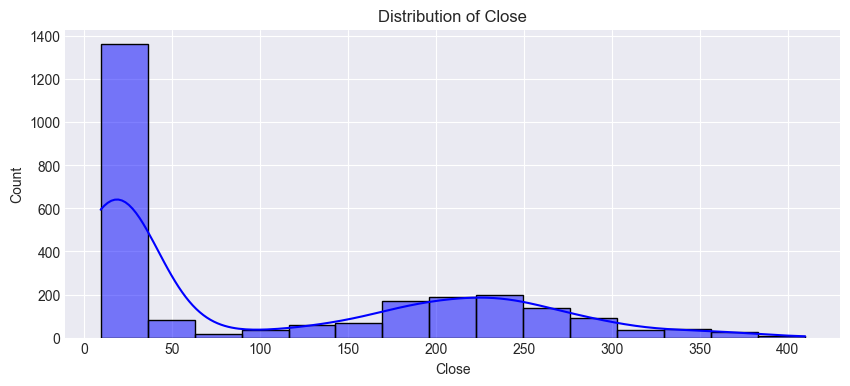

In [60]:
plot_hist(df, 'Close', 'blue')

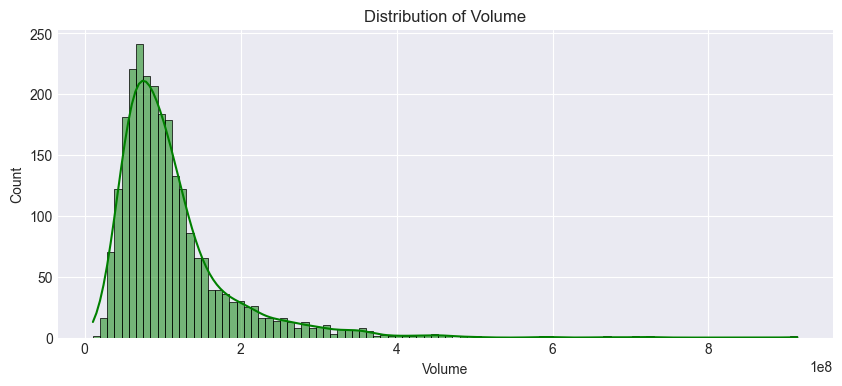

In [61]:
plot_hist(df, 'Volume', 'green')

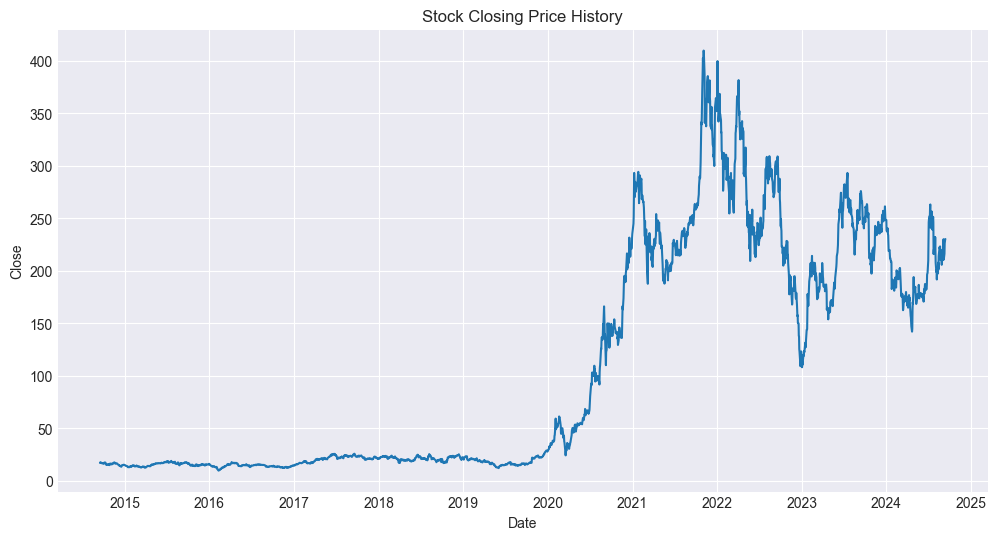

In [63]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=df['Date'], y=df['Close'])
plt.title("Stock Closing Price History")
plt.savefig("stock_price_history.png")

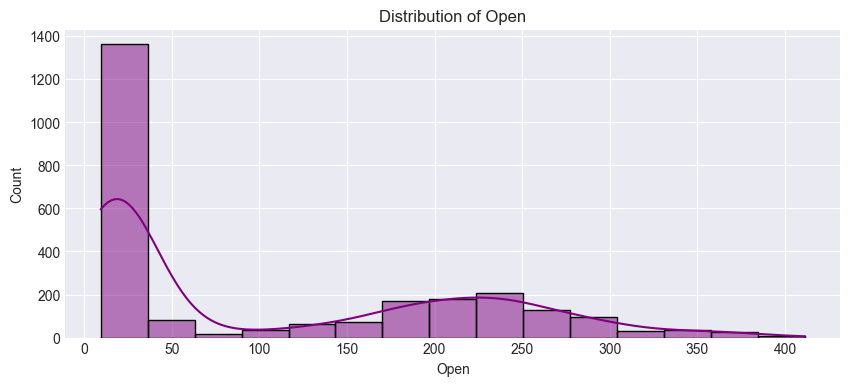

In [62]:
plot_hist(df, 'Open', 'purple')

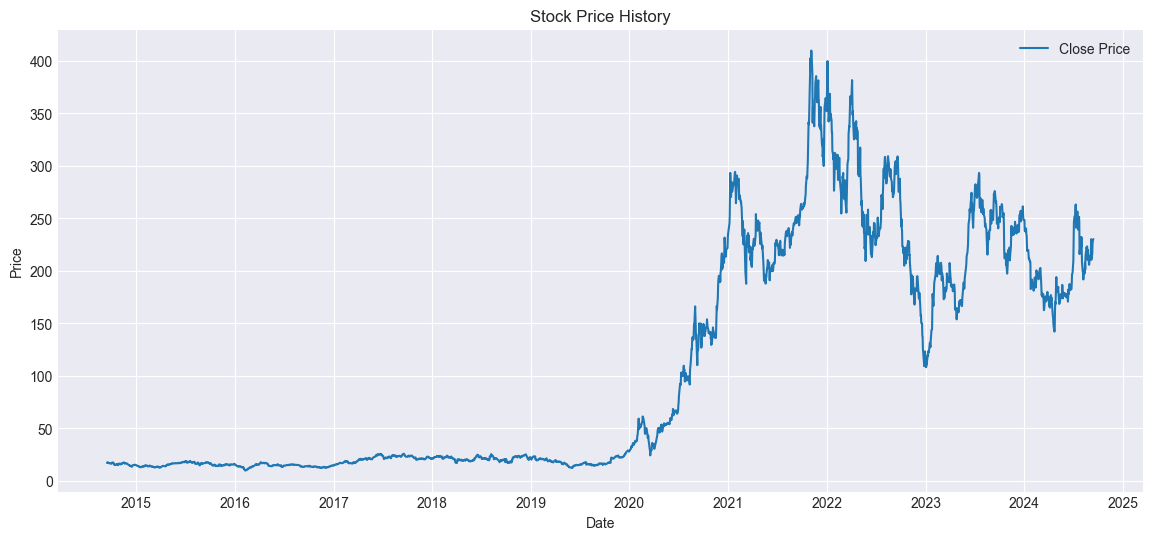

In [64]:
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', linewidth=1.5)
plt.title('Stock Price History')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

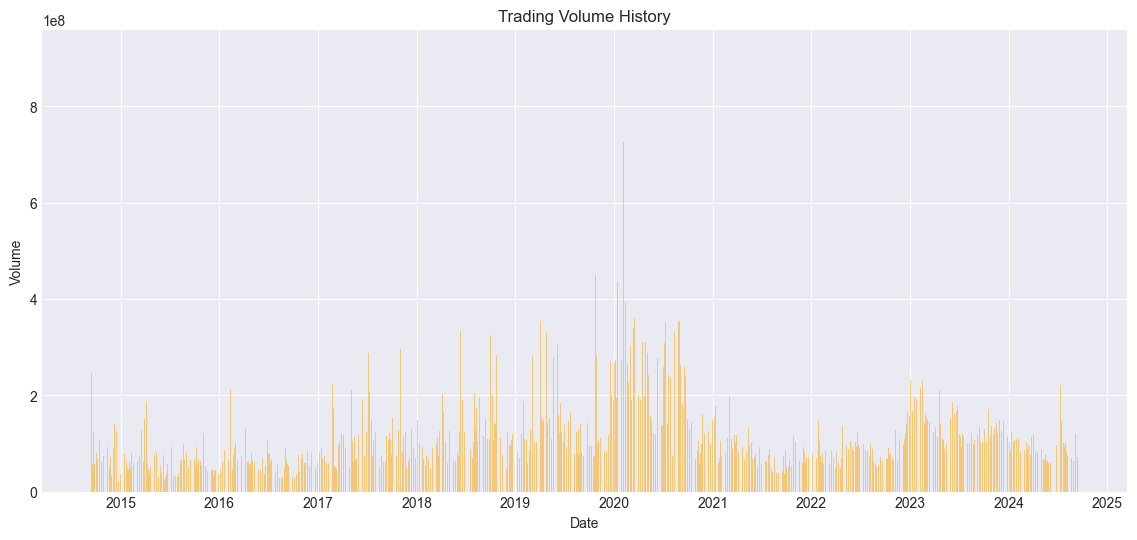

In [65]:
plt.figure(figsize=(14, 6))
plt.bar(df['Date'], df['Volume'], color='orange', alpha=0.5)
plt.title('Trading Volume History')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

In [66]:

df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

In [67]:
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

In [68]:
df['Daily_Return'] = df['Close'].pct_change()

In [70]:
df['Volatility'] = df['Daily_Return'].rolling(window=20).std()

In [71]:
exp1 = df['Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [72]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [73]:
df['RSI'] = calculate_rsi(df['Close'])

In [74]:
print(f"Shape before dropna: {df.shape}")
df.dropna(inplace=True)
print(f"Shape after dropna: {df.shape}")

Shape before dropna: (2517, 14)
Shape after dropna: (2468, 14)


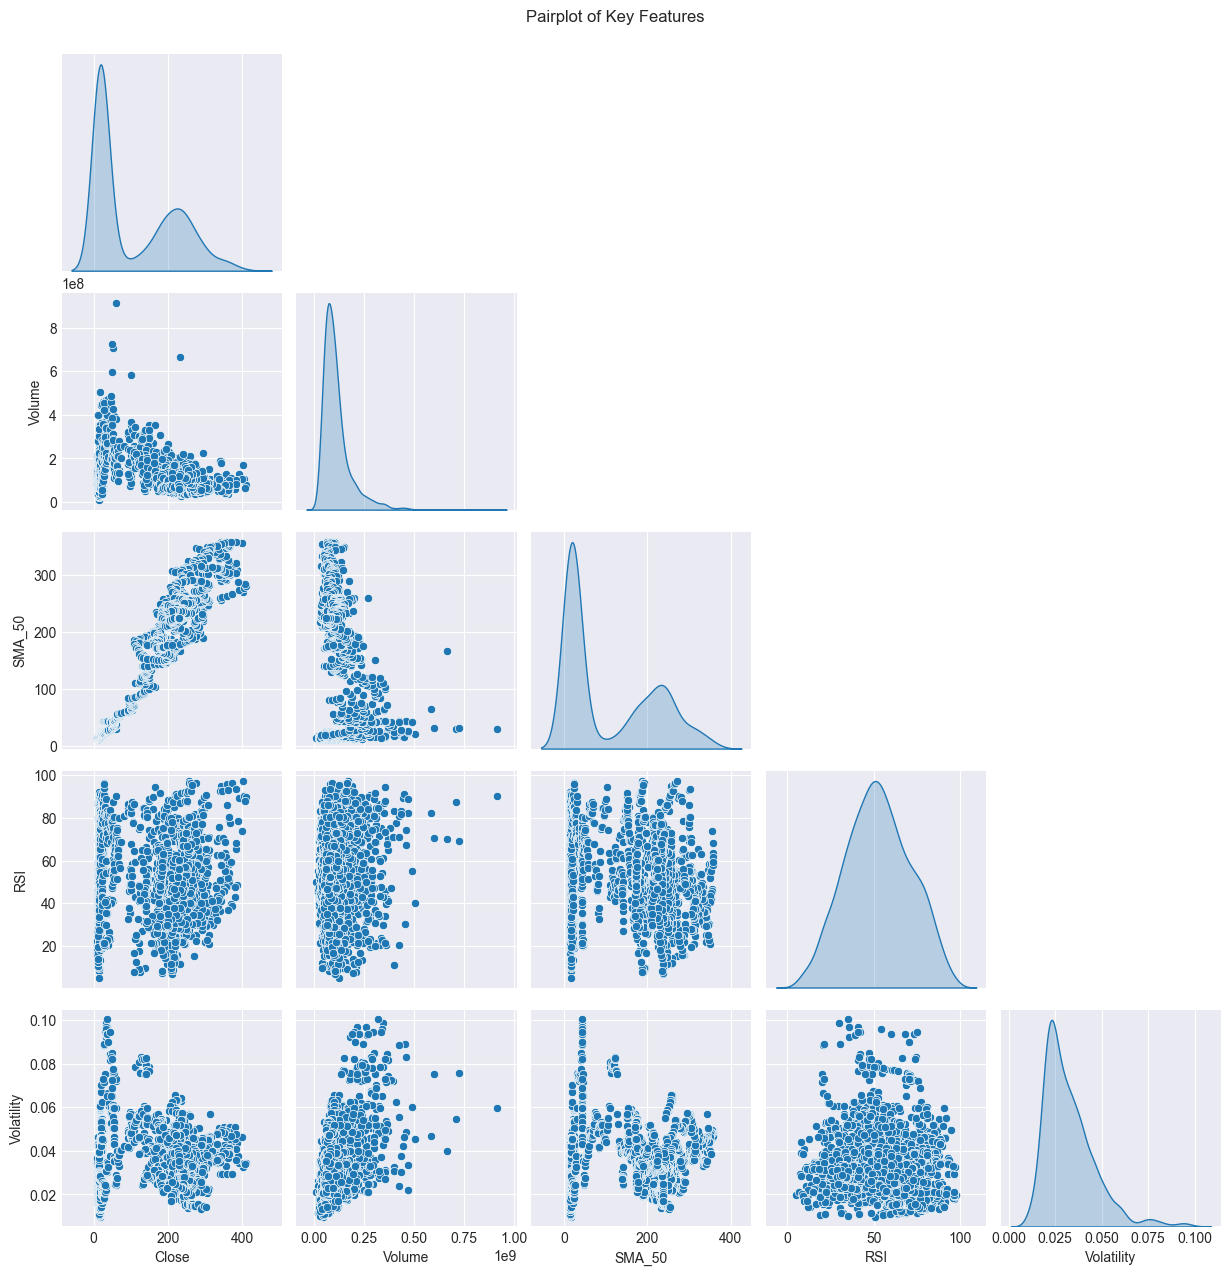

In [75]:
subset_cols = ['Close', 'Volume', 'SMA_50', 'RSI', 'Volatility']
sns.pairplot(df[subset_cols], diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Key Features', y=1.02)
plt.show()

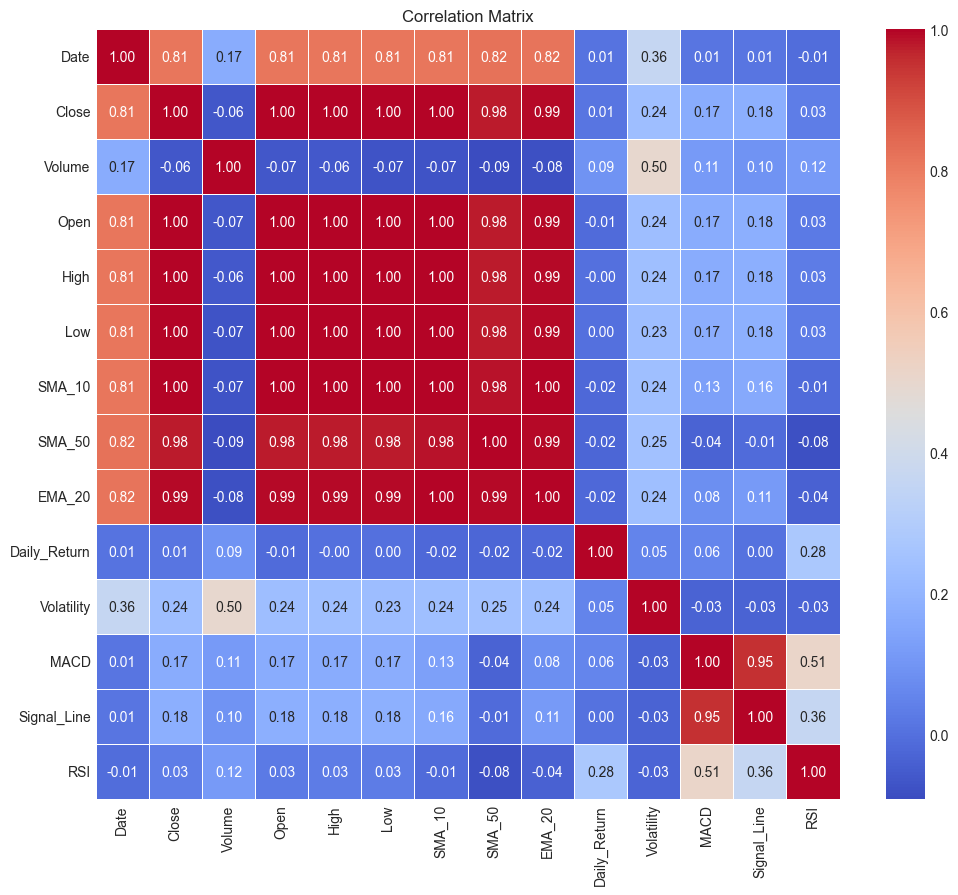

In [76]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

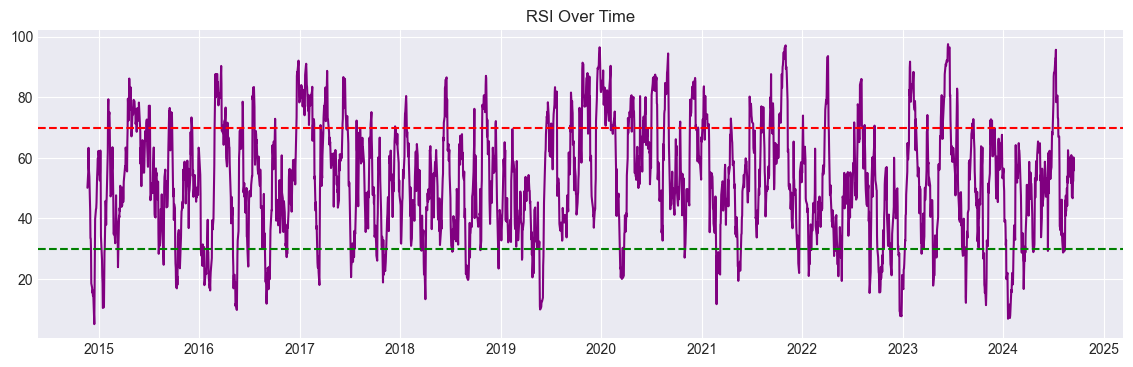

In [77]:
plt.figure(figsize=(14, 4))
plt.plot(df['Date'], df['RSI'], color='purple')
plt.axhline(70, linestyle='--', color='red')
plt.axhline(30, linestyle='--', color='green')
plt.title('RSI Over Time')
plt.show()

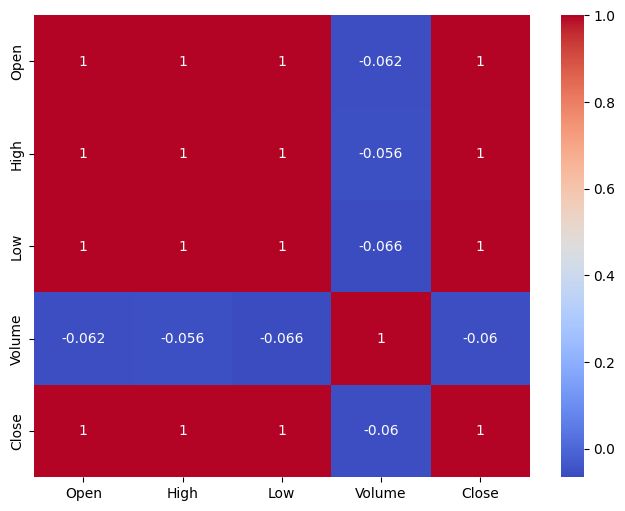

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Open', 'High', 'Low', 'Volume', 'Close']].corr(), annot=True, cmap='coolwarm')
plt.savefig("stock_correlation.png")

In [78]:
features = ['Open', 'High', 'Low', 'Volume', 'SMA_10', 'SMA_50', 'EMA_20', 'RSI', 'MACD']
X = df[features]
y = df['Close']


In [79]:

split_point = int(len(df) * 0.8)

In [80]:
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

In [81]:
print(f"Train Size: {X_train.shape[0]}, Test Size: {X_test.shape[0]}")

Train Size: 1974, Test Size: 494


In [82]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [83]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
print("Linear Regression Trained.")

Linear Regression Trained.


In [84]:
lr_pred = lr_model.predict(X_test_scaled)
print("Linear Regression Metrics:")
print(f"MSE: {mean_squared_error(y_test, lr_pred):.4f}")
print(f"R2: {r2_score(y_test, lr_pred):.4f}")

Linear Regression Metrics:
MSE: 6.3420
R2: 0.9957


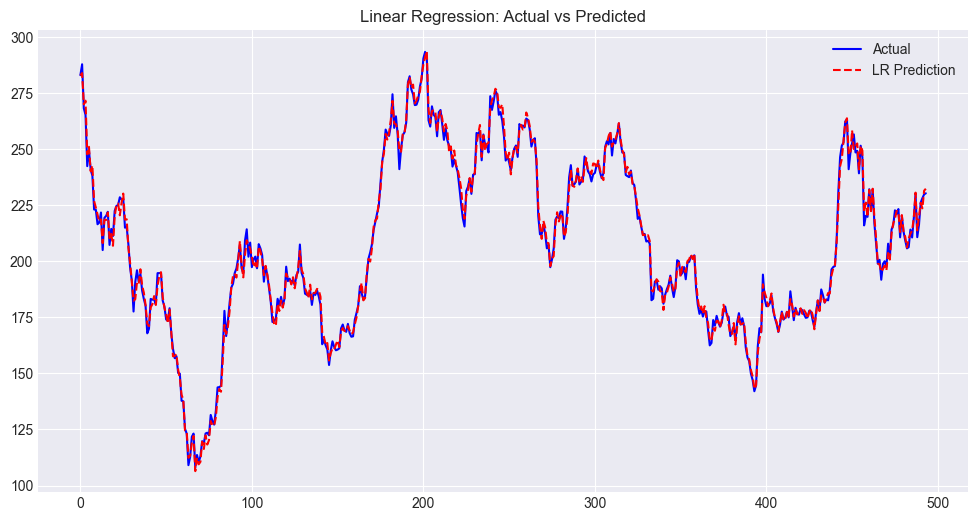

In [85]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(lr_pred, label='LR Prediction', color='red', linestyle='--')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

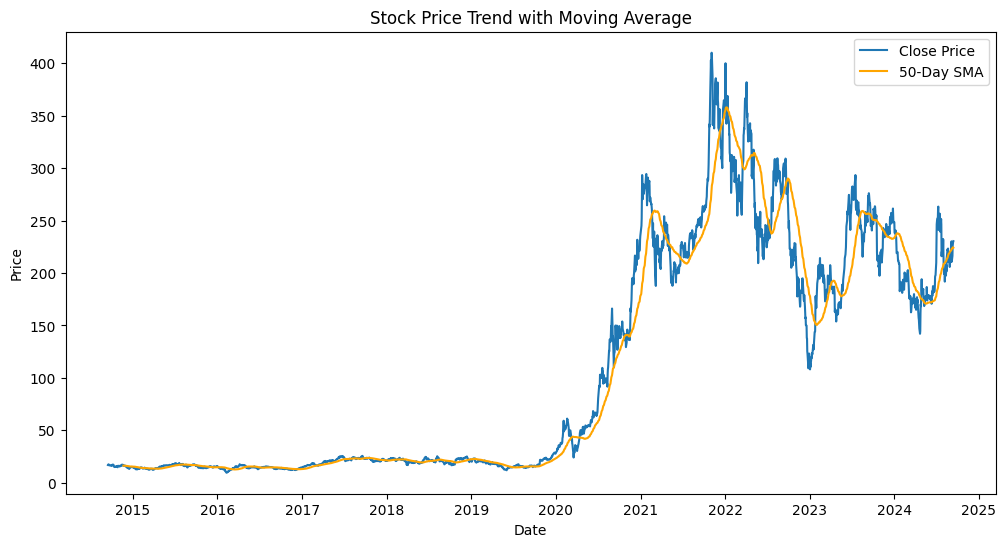

In [15]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Close', label='Close Price')
sns.lineplot(data=df, x='Date', y='SMA_50', label='50-Day SMA', color='orange')
plt.title('Stock Price Trend with Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

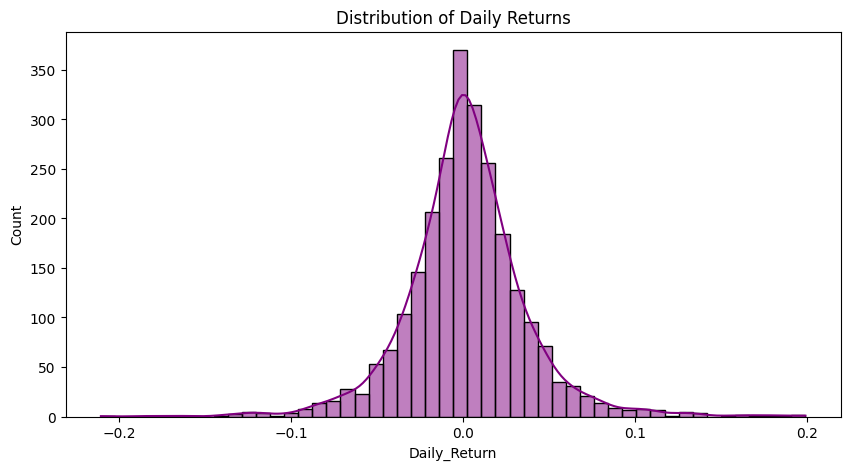

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Daily_Return'].dropna(), bins=50, kde=True, color='purple')
plt.title('Distribution of Daily Returns')
plt.show()

In [87]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [88]:
rf_pred = rf_model.predict(X_test_scaled)
print("Random Forest Metrics:")
print(f"MSE: {mean_squared_error(y_test, rf_pred):.4f}")
print(f"R2: {r2_score(y_test, rf_pred):.4f}")

Random Forest Metrics:
MSE: 45.0889
R2: 0.9691


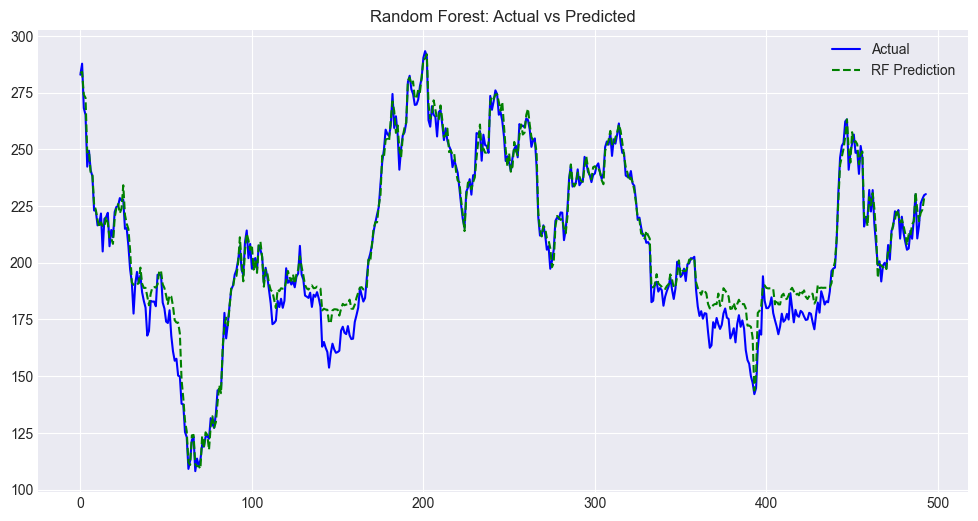

In [89]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(rf_pred, label='RF Prediction', color='green', linestyle='--')
plt.title('Random Forest: Actual vs Predicted')
plt.legend()
plt.show()

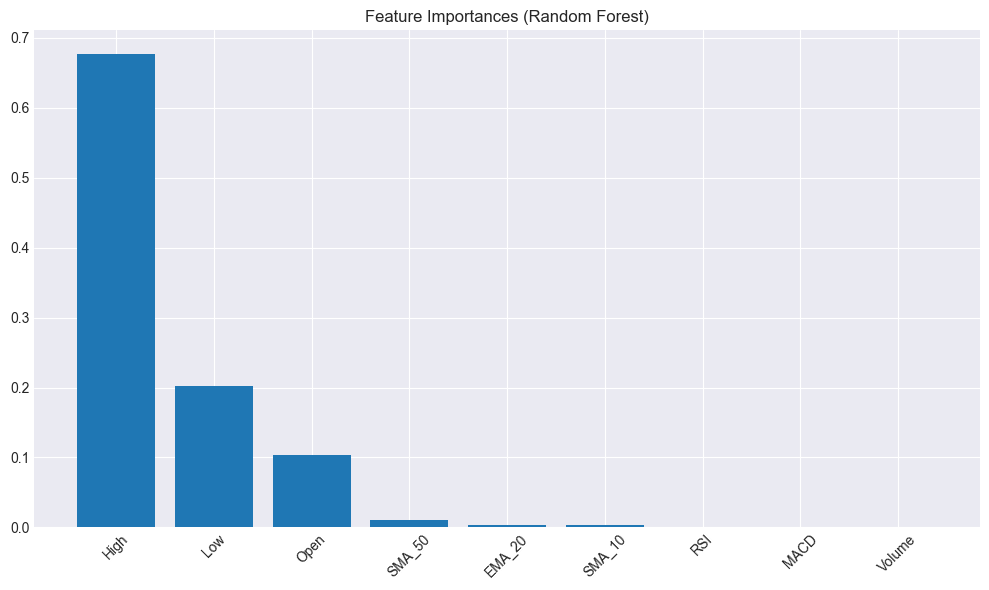

In [90]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

In [92]:
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_scaled, y_train)


,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [93]:
gb_pred = gb_model.predict(X_test_scaled)
print(f"Gradient Boosting R2: {r2_score(y_test, gb_pred):.4f}")

Gradient Boosting R2: 0.9487


In [94]:
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

,estimator,Ridge()
,param_grid,"{'alpha': [0.1, 1.0, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,0.1


In [95]:
print(f"Best Alpha for Ridge: {grid_search.best_params_}")
best_ridge = grid_search.best_estimator_

Best Alpha for Ridge: {'alpha': 0.1}


In [96]:
ridge_pred = best_ridge.predict(X_test_scaled)
print(f"Tuned Ridge R2: {r2_score(y_test, ridge_pred):.4f}")

Tuned Ridge R2: 0.9955


In [97]:
scaler_lstm = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler_lstm.fit_transform(df[['Close']].values)

In [98]:
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [99]:
time_step = 60
X_lstm, y_lstm = create_dataset(data_scaled, time_step)
print(f"LSTM Dataset Shape: {X_lstm.shape}")

LSTM Dataset Shape: (2407, 60)


In [100]:
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

In [101]:
train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(Dropout(0.2)) 
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

In [103]:
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [107]:
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,555 (595.92 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 101,704 (397.29 KB)

In [108]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [109]:
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=20, 
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0026 - val_loss: 0.0103
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0021 - val_loss: 0.0091
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0

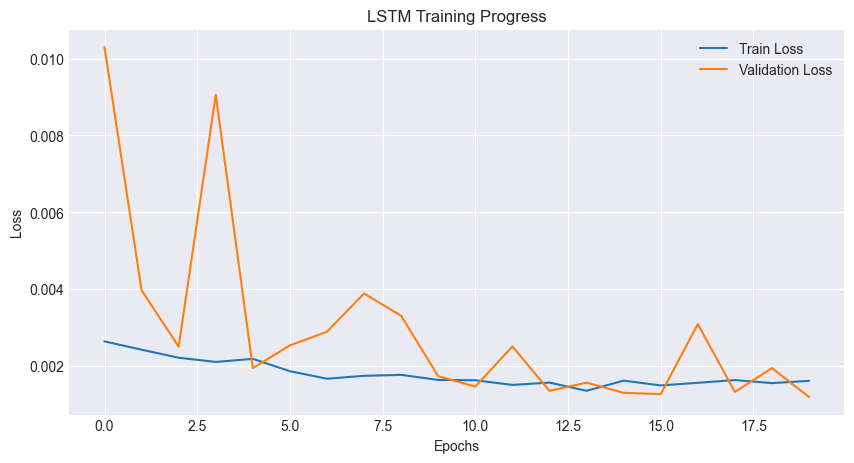

In [110]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [111]:
lstm_predict = lstm_model.predict(X_test_lstm)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [112]:
lstm_predict_inv = scaler_lstm.inverse_transform(lstm_predict)
y_test_lstm_inv = scaler_lstm.inverse_transform(y_test_lstm.reshape(-1, 1))

In [113]:
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm_inv, lstm_predict_inv))
print(f"LSTM RMSE: {lstm_rmse:.4f}")

LSTM RMSE: 13.8213


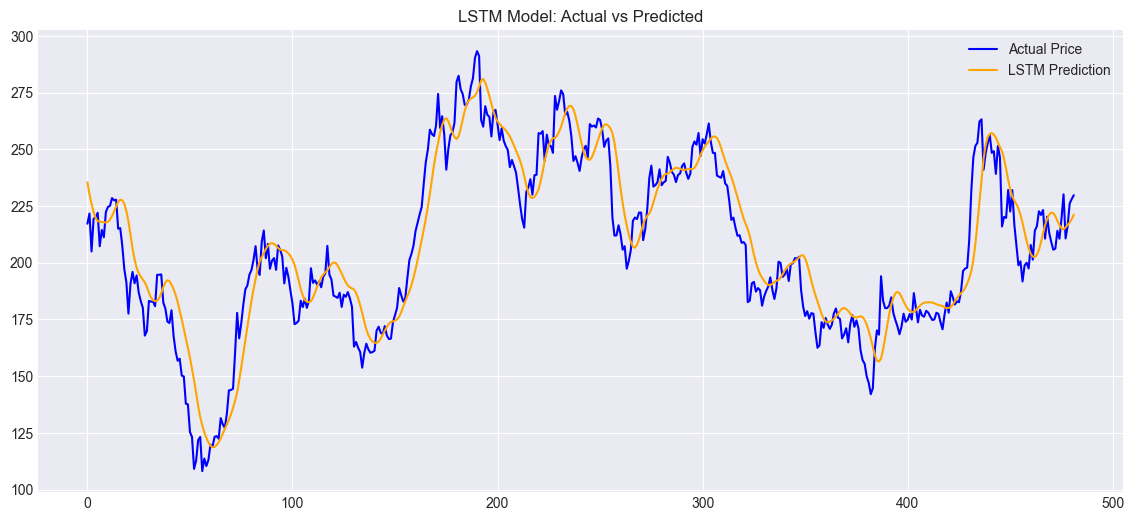

In [114]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_lstm_inv, label='Actual Price', color='blue')
plt.plot(lstm_predict_inv, label='LSTM Prediction', color='orange')
plt.title('LSTM Model: Actual vs Predicted')
plt.legend()
plt.show()

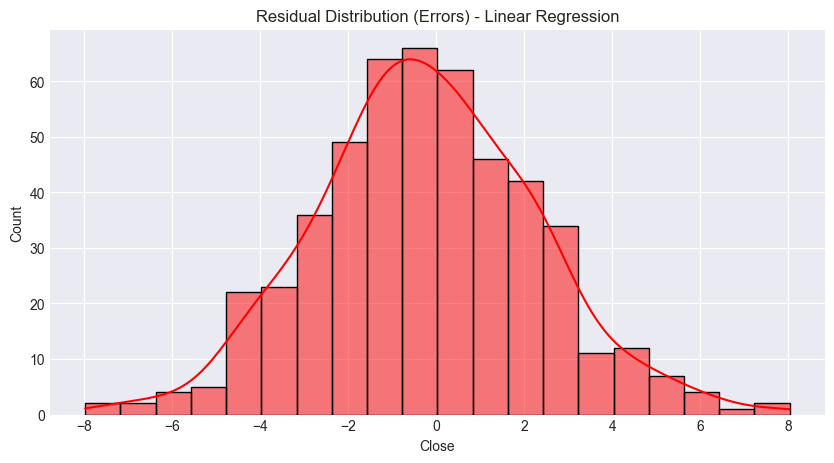

In [115]:
residuals = y_test - lr_pred
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='red')
plt.title('Residual Distribution (Errors) - Linear Regression')
plt.show()

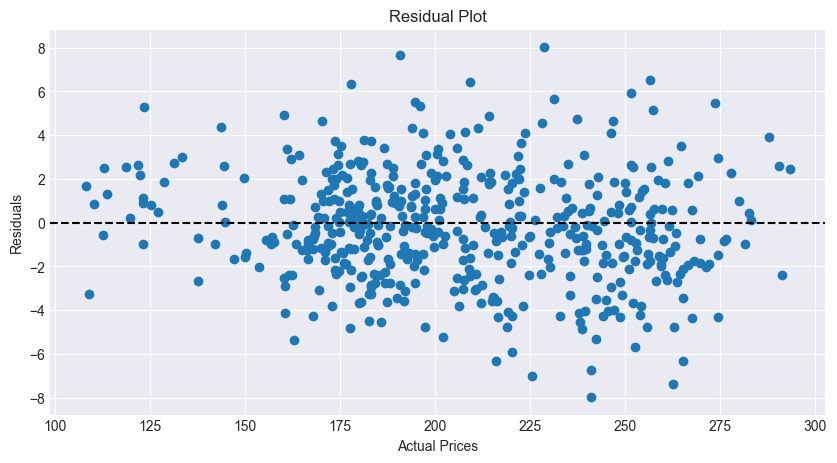

In [116]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [117]:
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Tuned Ridge'],
    'R2 Score': [r2_score(y_test, lr_pred), r2_score(y_test, rf_pred), r2_score(y_test, gb_pred), r2_score(y_test, ridge_pred)]
})

In [118]:
display(model_comparison.sort_values(by='R2 Score', ascending=False))

,Model,R2 Score
0,Linear Regression,0.995657
3,Tuned Ridge,0.995452
1,Random Forest,0.969122
2,Gradient Boosting,0.948650


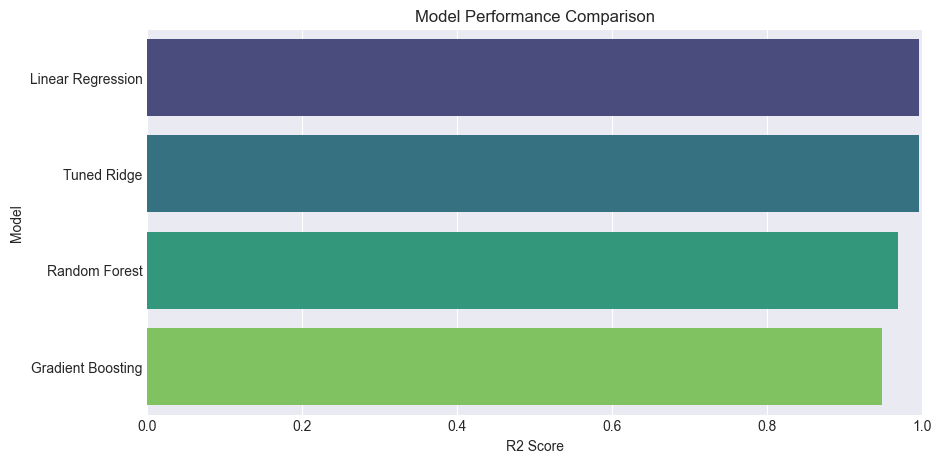

In [119]:
plt.figure(figsize=(10, 5))
sns.barplot(x='R2 Score', y='Model', data=model_comparison.sort_values(by='R2 Score', ascending=False), palette='viridis')
plt.title('Model Performance Comparison')
plt.xlim(0, 1.0)
plt.show()

In [121]:
joblib.dump(lr_model, f'{MODEL_DIR}/stock_lr_model.pkl')

['models/stock_lr_model.pkl']

In [122]:
joblib.dump(scaler, f'{MODEL_DIR}/stock_scaler.pkl')

['models/stock_scaler.pkl']

In [123]:
lstm_model.save(f'{MODEL_DIR}/stock_lstm_model.h5')

In [124]:
joblib.dump(rf_model, f'{MODEL_DIR}/stock_rf_model.pkl')

['models/stock_rf_model.pkl']

In [125]:
joblib.dump(features, f'{MODEL_DIR}/stock_features.pkl')

['models/stock_features.pkl']

In [126]:
saved_files = os.listdir(MODEL_DIR)
print(f"Files currently in {MODEL_DIR}: {saved_files}")

Files currently in models: ['stock_features.pkl', 'stock_lr_model.pkl', 'stock_lstm_model.h5', 'stock_rf_model.pkl', 'stock_scaler.pkl']
